## Import Libraries

In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [42]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [43]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [44]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [45]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [47]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D,Flatten, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, MaxPool2D,Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### ResNet

In [48]:
def ResNet(shape = (28,28,3)):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    inputs = Input(shape)
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(inputs) 
    
    conv_2_1 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(conv_1)
    conv_2_1 = Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = add([conv_1, conv_2_1])
    out_2_1 = Activation('relu')(add_2_1)
    
    conv_2_2 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(out_2_1)
    conv_2_2 = Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = add([out_2_1, conv_2_2])
    out_2_2 = Activation('relu')(add_2_1)
    
    pool_2 = MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = Conv2D(256, kernel_size = 1, strides = 1)(pool_2)
    
    conv_3_1 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_3_0)
    conv_3_1 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = add([conv_3_0, conv_3_1])
    out_3_1 = Activation('relu')(add_3_1)
    
    conv_3_2 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(out_3_1)
    conv_3_2 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = add([out_3_1, conv_3_2])
    out_3_2 = Activation('relu')(add_3_2)
    
    pool_3 = MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_4_0)
    conv_4_1 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = add([conv_4_0, conv_4_1])
    out_4_1 = Activation('relu')(add_4_1)
    
    pool_4 = MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = Flatten()(pool_4)
    img_features = Dense(512, activation = 'relu')(img_features)
    img_features = Dropout(rate = 0.5)(img_features)
    img_features = Dense(512, activation = 'relu')(img_features)
    img_features = Dropout(rate = 0.5)(img_features)
    
    # Output layer
    outputs = Dense(10, activation = 'softmax')(img_features)
    
    model = Model(inputs = inputs, outputs = outputs)
                    
    return model

In [49]:
model = ResNet()

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 28, 28, 128)  3584        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_96[0][0]                  
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_97[0][0]                  
____________________________________________________________________________________________

In [50]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [51]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 300
    model_number = 0
    history = []
    batch_size = 1
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/300
1789/1792 [============================>.] - ETA: 0s - loss: 2.3078 - accuracy: 0.1062
Epoch 00001: val_loss improved from inf to 2.29929, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3079 - accuracy: 0.1060 - val_loss: 2.2993 - val_accuracy: 0.0898 - lr: 1.0000e-04
Epoch 2/300
1783/1792 [============================>.] - ETA: 0s - loss: 2.3057 - accuracy: 0.1088
Epoch 00002: val_loss did not improve from 2.29929
1792/1792 [==============================] - 8s 4ms/step - loss: 2.3057 - accuracy: 0.1088 - val_loss: 2.3013 - val_accuracy: 0.1211 - lr: 1.0000e-04
Epoch 3/300
1781/1792 [============================>.] - ETA: 0s - loss: 2.3004 - accuracy: 0.1089
Epoch 00003: val_loss improved from 2.29929 to 2.27932, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3004 - accuracy: 0.1083 - val_loss: 2.2793 - val_acc

Epoch 27/300
1788/1792 [============================>.] - ETA: 0s - loss: 0.9226 - accuracy: 0.7047
Epoch 00027: val_loss did not improve from 0.68187
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9292 - accuracy: 0.7037 - val_loss: 0.7951 - val_accuracy: 0.7578 - lr: 1.0000e-04
Epoch 28/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.9188 - accuracy: 0.7063
Epoch 00028: val_loss did not improve from 0.68187
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9185 - accuracy: 0.7065 - val_loss: 0.8405 - val_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 29/300
1787/1792 [============================>.] - ETA: 0s - loss: 0.9109 - accuracy: 0.7012
Epoch 00029: val_loss did not improve from 0.68187
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9100 - accuracy: 0.7015 - val_loss: 0.8077 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 30/300
1782/1792 [============================>.] - ETA: 0s - loss: 0.8678 - accuracy: 0.72

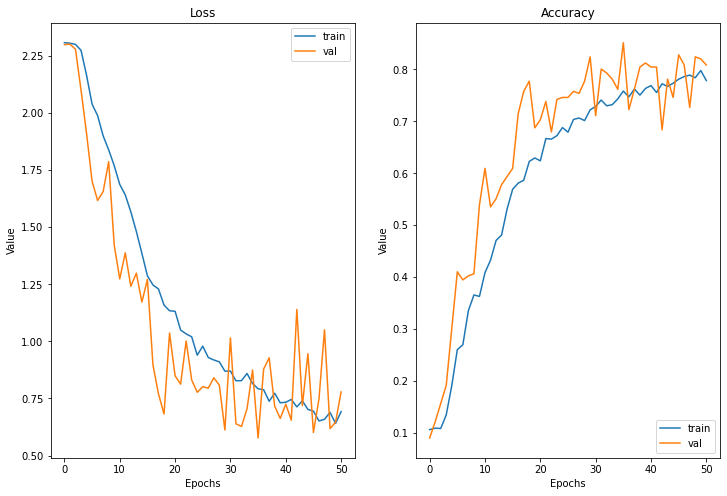

*******************number_2_kfold_model*******************
Epoch 1/300
1783/1792 [============================>.] - ETA: 0s - loss: 2.3088 - accuracy: 0.0953
Epoch 00001: val_loss improved from inf to 2.30174, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3089 - accuracy: 0.0949 - val_loss: 2.3017 - val_accuracy: 0.1484 - lr: 1.0000e-04
Epoch 2/300
1786/1792 [============================>.] - ETA: 0s - loss: 2.3034 - accuracy: 0.1092
Epoch 00002: val_loss did not improve from 2.30174
1792/1792 [==============================] - 9s 5ms/step - loss: 2.3032 - accuracy: 0.1094 - val_loss: 2.3134 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 3/300
1786/1792 [============================>.] - ETA: 0s - loss: 2.3036 - accuracy: 0.1013
Epoch 00003: val_loss improved from 2.30174 to 2.30020, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3036 - accuracy: 0.1027 - val_loss: 2.3002 - val_acc

Epoch 27/300
1785/1792 [============================>.] - ETA: 0s - loss: 0.9437 - accuracy: 0.7003
Epoch 00027: val_loss improved from 0.54742 to 0.46434, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 0.9422 - accuracy: 0.7003 - val_loss: 0.4643 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 28/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.9268 - accuracy: 0.6946
Epoch 00028: val_loss did not improve from 0.46434
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9283 - accuracy: 0.6942 - val_loss: 0.7085 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 29/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.7030
Epoch 00029: val_loss did not improve from 0.46434
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9245 - accuracy: 0.7031 - val_loss: 0.6365 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 30/300
1791/1792 [============================>.] - E

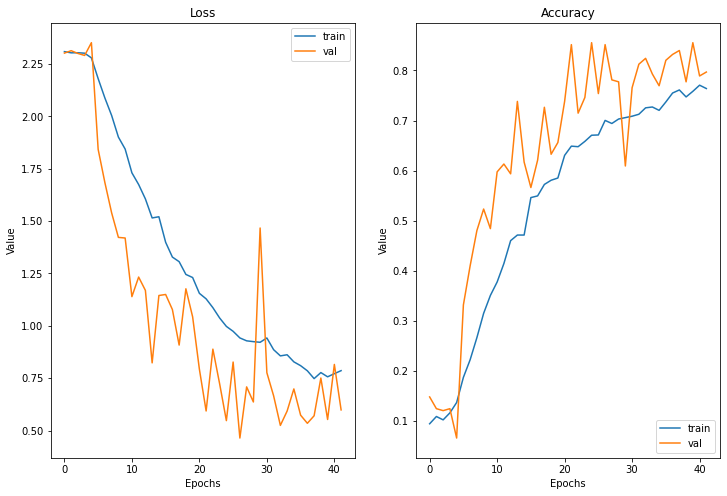

*******************number_3_kfold_model*******************
Epoch 1/300
1781/1792 [============================>.] - ETA: 0s - loss: 2.3084 - accuracy: 0.0971
Epoch 00001: val_loss improved from inf to 2.29892, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3082 - accuracy: 0.0977 - val_loss: 2.2989 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 2/300
1781/1792 [============================>.] - ETA: 0s - loss: 2.3034 - accuracy: 0.1072
Epoch 00002: val_loss improved from 2.29892 to 2.29850, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3034 - accuracy: 0.1066 - val_loss: 2.2985 - val_accuracy: 0.1094 - lr: 1.0000e-04
Epoch 3/300
1781/1792 [============================>.] - ETA: 0s - loss: 2.2980 - accuracy: 0.0999
Epoch 00003: val_loss improved from 2.29850 to 2.26258, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2981 - accurac

Epoch 27/300
1781/1792 [============================>.] - ETA: 0s - loss: 0.9561 - accuracy: 0.6923
Epoch 00027: val_loss did not improve from 0.53194
1792/1792 [==============================] - 8s 5ms/step - loss: 0.9548 - accuracy: 0.6925 - val_loss: 0.6093 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 28/300
1784/1792 [============================>.] - ETA: 0s - loss: 0.9046 - accuracy: 0.7080
Epoch 00028: val_loss did not improve from 0.53194
1792/1792 [==============================] - 8s 5ms/step - loss: 0.9023 - accuracy: 0.7081 - val_loss: 0.8163 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 29/300
1788/1792 [============================>.] - ETA: 0s - loss: 0.9177 - accuracy: 0.7075
Epoch 00029: val_loss did not improve from 0.53194
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9158 - accuracy: 0.7081 - val_loss: 0.6245 - val_accuracy: 0.8320 - lr: 1.0000e-04
Epoch 30/300
1787/1792 [============================>.] - ETA: 0s - loss: 0.8982 - accuracy: 0.70

Epoch 54/300
1790/1792 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.7955
Epoch 00054: val_loss did not improve from 0.39863
1792/1792 [==============================] - 8s 4ms/step - loss: 0.6832 - accuracy: 0.7952 - val_loss: 0.5834 - val_accuracy: 0.8594 - lr: 1.0000e-04
Epoch 55/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.7856
Epoch 00055: val_loss did not improve from 0.39863
1792/1792 [==============================] - 8s 5ms/step - loss: 0.6675 - accuracy: 0.7857 - val_loss: 0.7617 - val_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 56/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.7856
Epoch 00056: val_loss did not improve from 0.39863
1792/1792 [==============================] - 8s 5ms/step - loss: 0.6864 - accuracy: 0.7857 - val_loss: 0.4746 - val_accuracy: 0.8828 - lr: 1.0000e-04
Epoch 57/300
1789/1792 [============================>.] - ETA: 0s - loss: 0.6484 - accuracy: 0.78

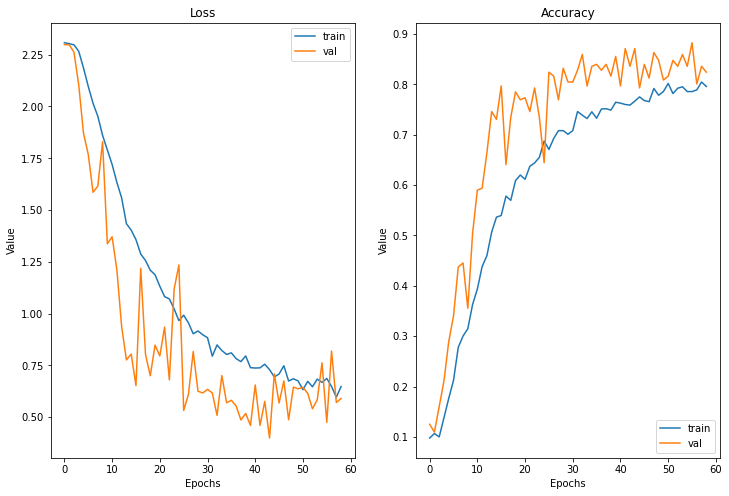

*******************number_4_kfold_model*******************
Epoch 1/300
1782/1792 [============================>.] - ETA: 0s - loss: 2.3092 - accuracy: 0.0943
Epoch 00001: val_loss improved from inf to 2.29904, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3093 - accuracy: 0.0938 - val_loss: 2.2990 - val_accuracy: 0.1484 - lr: 1.0000e-04
Epoch 2/300
1790/1792 [============================>.] - ETA: 0s - loss: 2.3039 - accuracy: 0.1089
Epoch 00002: val_loss improved from 2.29904 to 2.29833, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3039 - accuracy: 0.1088 - val_loss: 2.2983 - val_accuracy: 0.1016 - lr: 1.0000e-04
Epoch 3/300
1792/1792 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.1094
Epoch 00003: val_loss improved from 2.29833 to 2.27844, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 4ms/step - loss: 2.3036 - accurac

Epoch 27/300
1782/1792 [============================>.] - ETA: 0s - loss: 1.0034 - accuracy: 0.6734
Epoch 00027: val_loss did not improve from 0.51813
1792/1792 [==============================] - 8s 4ms/step - loss: 1.0085 - accuracy: 0.6713 - val_loss: 1.2925 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 28/300
1780/1792 [============================>.] - ETA: 0s - loss: 0.9626 - accuracy: 0.6815
Epoch 00028: val_loss did not improve from 0.51813
1792/1792 [==============================] - 8s 4ms/step - loss: 0.9603 - accuracy: 0.6825 - val_loss: 1.0592 - val_accuracy: 0.6953 - lr: 1.0000e-04
Epoch 29/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.9681 - accuracy: 0.6946
Epoch 00029: val_loss did not improve from 0.51813
1792/1792 [==============================] - 8s 5ms/step - loss: 0.9676 - accuracy: 0.6948 - val_loss: 0.5480 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 30/300
1791/1792 [============================>.] - ETA: 0s - loss: 0.9264 - accuracy: 0.70

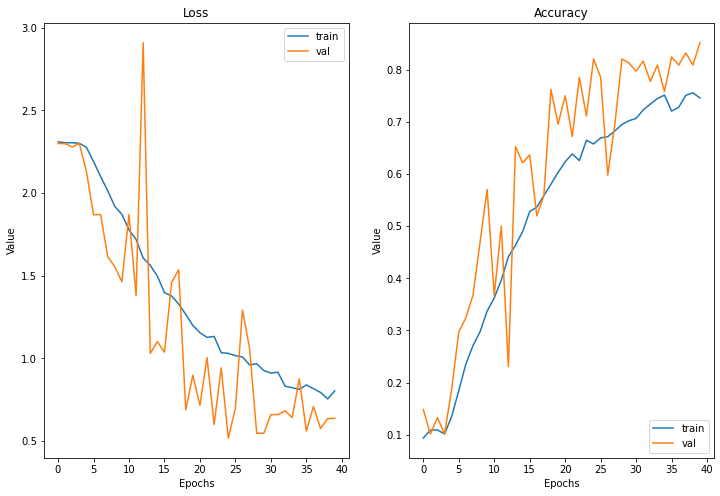

*******************number_5_kfold_model*******************
Epoch 1/300
1785/1792 [============================>.] - ETA: 0s - loss: 2.3082 - accuracy: 0.1064
Epoch 00001: val_loss improved from inf to 2.30012, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3083 - accuracy: 0.1066 - val_loss: 2.3001 - val_accuracy: 0.0820 - lr: 1.0000e-04
Epoch 2/300
1782/1792 [============================>.] - ETA: 0s - loss: 2.3017 - accuracy: 0.0988
Epoch 00002: val_loss improved from 2.30012 to 2.29091, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 4ms/step - loss: 2.3016 - accuracy: 0.0988 - val_loss: 2.2909 - val_accuracy: 0.1016 - lr: 1.0000e-04
Epoch 3/300
1787/1792 [============================>.] - ETA: 0s - loss: 2.2803 - accuracy: 0.1231
Epoch 00003: val_loss improved from 2.29091 to 2.16876, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2804 - accurac

Epoch 53/300
1790/1792 [============================>.] - ETA: 0s - loss: 0.6629 - accuracy: 0.7911
Epoch 00053: val_loss did not improve from 0.51609
1792/1792 [==============================] - 8s 5ms/step - loss: 0.6624 - accuracy: 0.7913 - val_loss: 0.5895 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 54/300
1788/1792 [============================>.] - ETA: 0s - loss: 0.6365 - accuracy: 0.7942
Epoch 00054: val_loss improved from 0.51609 to 0.50819, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 0.6366 - accuracy: 0.7941 - val_loss: 0.5082 - val_accuracy: 0.8555 - lr: 1.0000e-04
Epoch 55/300
1787/1792 [============================>.] - ETA: 0s - loss: 0.5724 - accuracy: 0.8170
Epoch 00055: val_loss did not improve from 0.50819
1792/1792 [==============================] - 8s 4ms/step - loss: 0.5710 - accuracy: 0.8175 - val_loss: 0.5776 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 56/300
1790/1792 [============================>.] - E

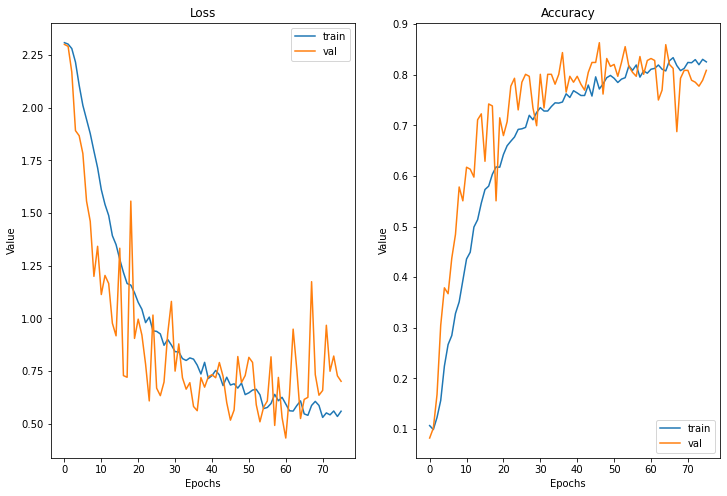

*******************number_6_kfold_model*******************
Epoch 1/300
1789/1792 [============================>.] - ETA: 0s - loss: 2.3073 - accuracy: 0.1107
Epoch 00001: val_loss improved from inf to 2.30674, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3073 - accuracy: 0.1105 - val_loss: 2.3067 - val_accuracy: 0.0781 - lr: 1.0000e-04
Epoch 2/300
1786/1792 [============================>.] - ETA: 0s - loss: 2.2987 - accuracy: 0.1249
Epoch 00002: val_loss improved from 2.30674 to 2.29828, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2987 - accuracy: 0.1244 - val_loss: 2.2983 - val_accuracy: 0.1289 - lr: 1.0000e-04
Epoch 3/300
1788/1792 [============================>.] - ETA: 0s - loss: 2.2739 - accuracy: 0.1381
Epoch 00003: val_loss improved from 2.29828 to 2.18180, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2733 - accurac

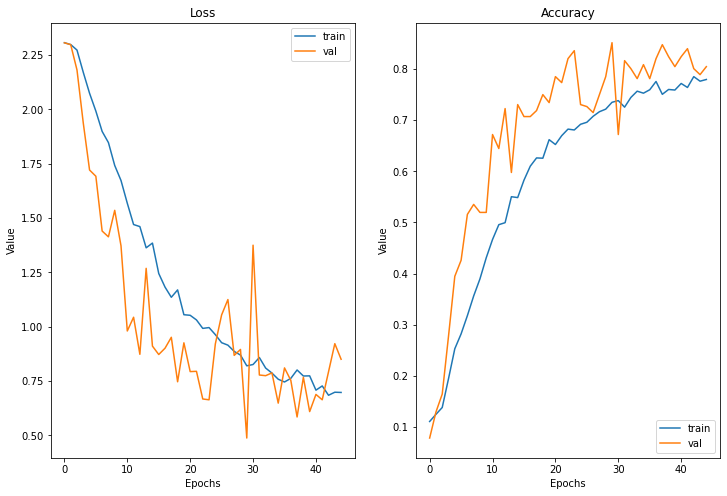

*******************number_7_kfold_model*******************
Epoch 1/300
1785/1792 [============================>.] - ETA: 0s - loss: 2.3075 - accuracy: 0.0980
Epoch 00001: val_loss improved from inf to 2.29645, saving model to model1_best_0.h5
1792/1792 [==============================] - 9s 5ms/step - loss: 2.3075 - accuracy: 0.0977 - val_loss: 2.2965 - val_accuracy: 0.1016 - lr: 1.0000e-04
Epoch 2/300
1790/1792 [============================>.] - ETA: 0s - loss: 2.3004 - accuracy: 0.1084
Epoch 00002: val_loss improved from 2.29645 to 2.27572, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3004 - accuracy: 0.1088 - val_loss: 2.2757 - val_accuracy: 0.1328 - lr: 1.0000e-04
Epoch 3/300
1787/1792 [============================>.] - ETA: 0s - loss: 2.2635 - accuracy: 0.1360
Epoch 00003: val_loss improved from 2.27572 to 1.96266, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2638 - accurac

Epoch 27/300
1785/1792 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.6930
Epoch 00027: val_loss did not improve from 0.67511
1792/1792 [==============================] - 8s 5ms/step - loss: 0.9268 - accuracy: 0.6931 - val_loss: 0.9215 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 28/300
1787/1792 [============================>.] - ETA: 0s - loss: 0.8890 - accuracy: 0.7040
Epoch 00028: val_loss did not improve from 0.67511
1792/1792 [==============================] - 8s 5ms/step - loss: 0.8888 - accuracy: 0.7042 - val_loss: 0.7108 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 29/300
1784/1792 [============================>.] - ETA: 0s - loss: 0.8339 - accuracy: 0.7298
Epoch 00029: val_loss improved from 0.67511 to 0.66647, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 4ms/step - loss: 0.8357 - accuracy: 0.7288 - val_loss: 0.6665 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 30/300
1791/1792 [============================>.] - E

Epoch 54/300
1786/1792 [============================>.] - ETA: 0s - loss: 0.6310 - accuracy: 0.7940
Epoch 00054: val_loss did not improve from 0.43241
1792/1792 [==============================] - 8s 5ms/step - loss: 0.6345 - accuracy: 0.7935 - val_loss: 0.5638 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 55/300
1787/1792 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.8041
Epoch 00055: val_loss did not improve from 0.43241
1792/1792 [==============================] - 8s 4ms/step - loss: 0.6414 - accuracy: 0.8047 - val_loss: 0.6951 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 56/300
1782/1792 [============================>.] - ETA: 0s - loss: 0.6388 - accuracy: 0.7901
Epoch 00056: val_loss did not improve from 0.43241
1792/1792 [==============================] - 8s 4ms/step - loss: 0.6369 - accuracy: 0.7907 - val_loss: 0.6007 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 57/300
1784/1792 [============================>.] - ETA: 0s - loss: 0.6164 - accuracy: 0.80

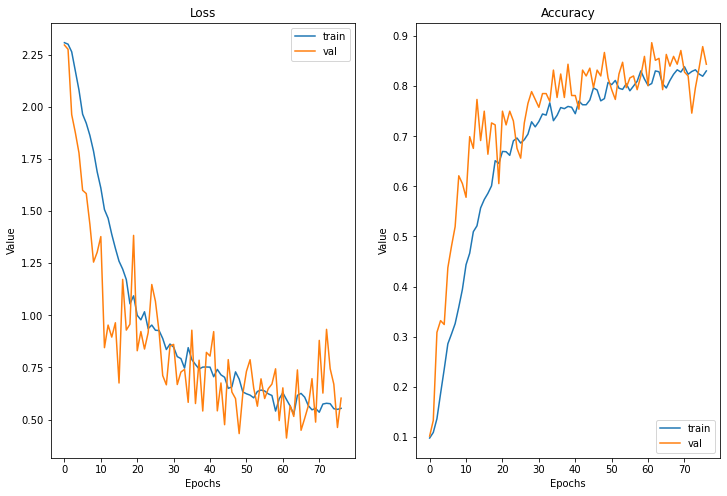

*******************number_8_kfold_model*******************
Epoch 1/300
1783/1792 [============================>.] - ETA: 0s - loss: 2.3096 - accuracy: 0.1004
Epoch 00001: val_loss improved from inf to 2.29482, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3097 - accuracy: 0.0999 - val_loss: 2.2948 - val_accuracy: 0.1367 - lr: 1.0000e-04
Epoch 2/300
1792/1792 [==============================] - ETA: 0s - loss: 2.3041 - accuracy: 0.1077
Epoch 00002: val_loss improved from 2.29482 to 2.29470, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.3041 - accuracy: 0.1077 - val_loss: 2.2947 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 3/300
1790/1792 [============================>.] - ETA: 0s - loss: 2.2953 - accuracy: 0.1190
Epoch 00003: val_loss improved from 2.29470 to 2.24320, saving model to model1_best_0.h5
1792/1792 [==============================] - 8s 5ms/step - loss: 2.2951 - accurac

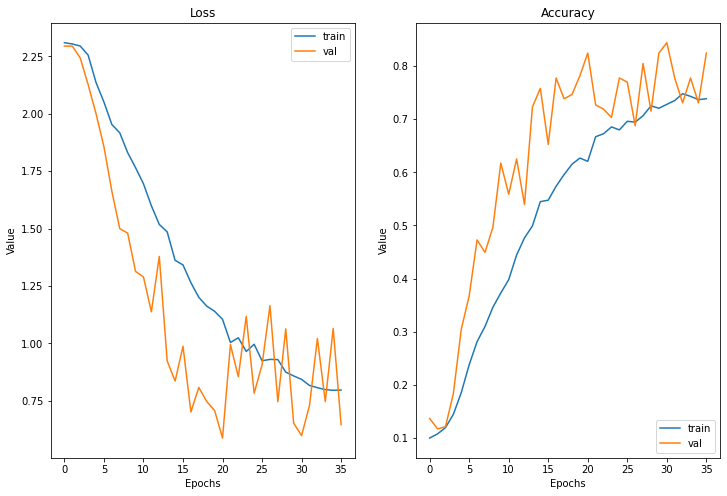

In [52]:
RS_train, RS_test = get_stacking(ResNet, X_trains, y_trains)

## Pickle 파일 저장

In [53]:
pickle.dump(RS_train, open("./pickle/RS_train.pkl", "wb"))
pickle.dump(RS_test, open("./pickle/RS_test.pkl", "wb"))